# 0. Preâmbulo 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from glob import glob
import re

from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

# 1. Importação e integração dos conjuntos de dados

In [2]:
file_list = glob('Dados/*.csv')
df_merged = pd.DataFrame(columns=['cod', 'nome', 'pvp'])

for idx,file in enumerate(file_list):
    df = pd.read_csv(file, sep=';', encoding='cp1252', decimal=',')
    file_name = file.split('\\')[-1]
    years = re.findall('\d+', file)
    if idx==0:
        date_start = '{}-01-01'.format(years[0][:4])
    else:
        date_start = '{}-03-01'.format(years[0][:4])
    date_end = '{}-03-01'.format(years[0][-4:])
    col_names1 = ['cod', 'nome', 'stock', 'localizacao', 'stock_tot', 'pvp', 'valor_vendas']
    col_names2 = pd.date_range(date_start, date_end, freq='MS').strftime('%Y-%m-%d').tolist()
    col_names3 = ['tot_uni']
    col_names = col_names1+col_names2+col_names3
    df.columns = col_names
    if idx!=len(file_list)-1:
        df = df.drop(columns=['stock_tot', 'localizacao', 'stock', 'valor_vendas', col_names2[-1], 'tot_uni'])
    else:
        df = df.drop(columns=['stock_tot', 'localizacao', 'stock', 'valor_vendas', 'tot_uni'])
    df_merged = pd.merge(df_merged, df, on=['cod', 'nome', 'pvp'], how='outer')

In [3]:
print('df_merged tem a quantidade vendida de medicamentos catalogados para "dor de garganta e rouquidão":')
print('- para {} medicamentos'.format(df_merged.shape[0]))
print('- em {} meses'.format(df_merged.iloc[:,3:].shape[1]))

df_merged tem a quantidade vendida de medicamentos catalogados para "dor de garganta e rouquidão":
- para 48 medicamentos
- em 123 meses


In [4]:
# colunas de df_merged
print(*df_merged.columns[:3], sep=' - ')
for i in range(12):
    print(*df_merged.columns[i*12+3:i*12+15], sep=' - ')

cod - nome - pvp
2013-01-01 - 2013-02-01 - 2013-03-01 - 2013-04-01 - 2013-05-01 - 2013-06-01 - 2013-07-01 - 2013-08-01 - 2013-09-01 - 2013-10-01 - 2013-11-01 - 2013-12-01
2014-01-01 - 2014-02-01 - 2014-03-01 - 2014-04-01 - 2014-05-01 - 2014-06-01 - 2014-07-01 - 2014-08-01 - 2014-09-01 - 2014-10-01 - 2014-11-01 - 2014-12-01
2015-01-01 - 2015-02-01 - 2015-03-01 - 2015-04-01 - 2015-05-01 - 2015-06-01 - 2015-07-01 - 2015-08-01 - 2015-09-01 - 2015-10-01 - 2015-11-01 - 2015-12-01
2016-01-01 - 2016-02-01 - 2016-03-01 - 2016-04-01 - 2016-05-01 - 2016-06-01 - 2016-07-01 - 2016-08-01 - 2016-09-01 - 2016-10-01 - 2016-11-01 - 2016-12-01
2017-01-01 - 2017-02-01 - 2017-03-01 - 2017-04-01 - 2017-05-01 - 2017-06-01 - 2017-07-01 - 2017-08-01 - 2017-09-01 - 2017-10-01 - 2017-11-01 - 2017-12-01
2018-01-01 - 2018-02-01 - 2018-03-01 - 2018-04-01 - 2018-05-01 - 2018-06-01 - 2018-07-01 - 2018-08-01 - 2018-09-01 - 2018-10-01 - 2018-11-01 - 2018-12-01
2019-01-01 - 2019-02-01 - 2019-03-01 - 2019-04-01 - 2019-05

In [5]:
# lista de medicamentos e respetivo preço
df_metainfo = df_merged[['cod', 'nome', 'pvp']]
with pd.option_context('display.max_rows', 5, 'display.min_rows', 25):
    display(df_metainfo)

,cod,nome,pvp
0,9313106,"Anginova, 0,25/1,5mg+400U x 20 comp chupar",8.27
1,4320396,"Collu-Hextril, 2 mg/mL-40 mL x 1 sol pulv bucal",7.05
...,...,...,...
46,5795729,"Strepfen Spray Mel e Limão , 16.2 mg/ml Frasco...",11.70
47,5753827,Orovox Spray Sol Pulv Buc 3 Mg/Ml 15Ml,6.60


In [6]:
del col_names, col_names1, col_names2, col_names3, date_start, date_end
del df, file, file_list, file_name, idx, years, i

# 2. Tratamento dos dados

## 2.1. Da tabela das quantidades vendidas para o volume de vendas

In [7]:
df_merged.iloc[:5, np.r_[2, 120:126]]

,pvp,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01
0,8.27,NaN,NaN,NaN,NaN,NaN,NaN
1,7.05,0.0,0.0,0.0,0.0,0.0,0.0
2,9.75,2.0,2.0,4.0,0.0,1.0,3.0
3,9.22,2.0,0.0,1.0,0.0,2.0,0.0
4,8.75,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# transformar dos dados de quantidade para volume de vendas
for col in df_merged.columns[3:]:
    df_merged[col] = df_merged['pvp'] * df_merged[col]

In [9]:
# sanity check
df_merged.iloc[:5, np.r_[2, 120:126]]

,pvp,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01
0,8.27,NaN,NaN,NaN,NaN,NaN,NaN
1,7.05,0.00,0.0,0.00,0.0,0.00,0.00
2,9.75,19.50,19.5,39.00,0.0,9.75,29.25
3,9.22,18.44,0.0,9.22,0.0,18.44,0.00
4,8.75,NaN,NaN,NaN,NaN,NaN,NaN


## 2.2. Organização da tabela em série temporal

In [10]:
df = df_merged.drop(columns=['nome','pvp']).set_index('cod').T
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2013-01-01 to 2023-03-01
Data columns (total 48 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   9313106  50 non-null     float64
 1   4320396  123 non-null    float64
 2   8834101  123 non-null    float64
 3   9969600  123 non-null    float64
 4   4895983  38 non-null     float64
 5   5407382  111 non-null    float64
 6   5407481  50 non-null     float64
 7   5470851  123 non-null    float64
 8   9703017  14 non-null     float64
 9   5211636  123 non-null    float64
 10  9908608  14 non-null     float64
 11  3700481  123 non-null    float64
 12  5154828  123 non-null    float64
 13  5336508  51 non-null     float64
 14  5164231  123 non-null    float64
 15  5182654  123 non-null    float64
 16  5154737  123 non-null    float64
 17  5301619  26 non-null     float64
 18  5182647  123 non-null    float64
 19  2889384  86 non-null     float64
 20  8232827  123 non-null    float64
 2

# 3. Análise exploratória rápida

In [11]:
numero_medicamentos = len(df.columns)

In [12]:
fig = px.line(df, x=df.index, y=df.columns)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

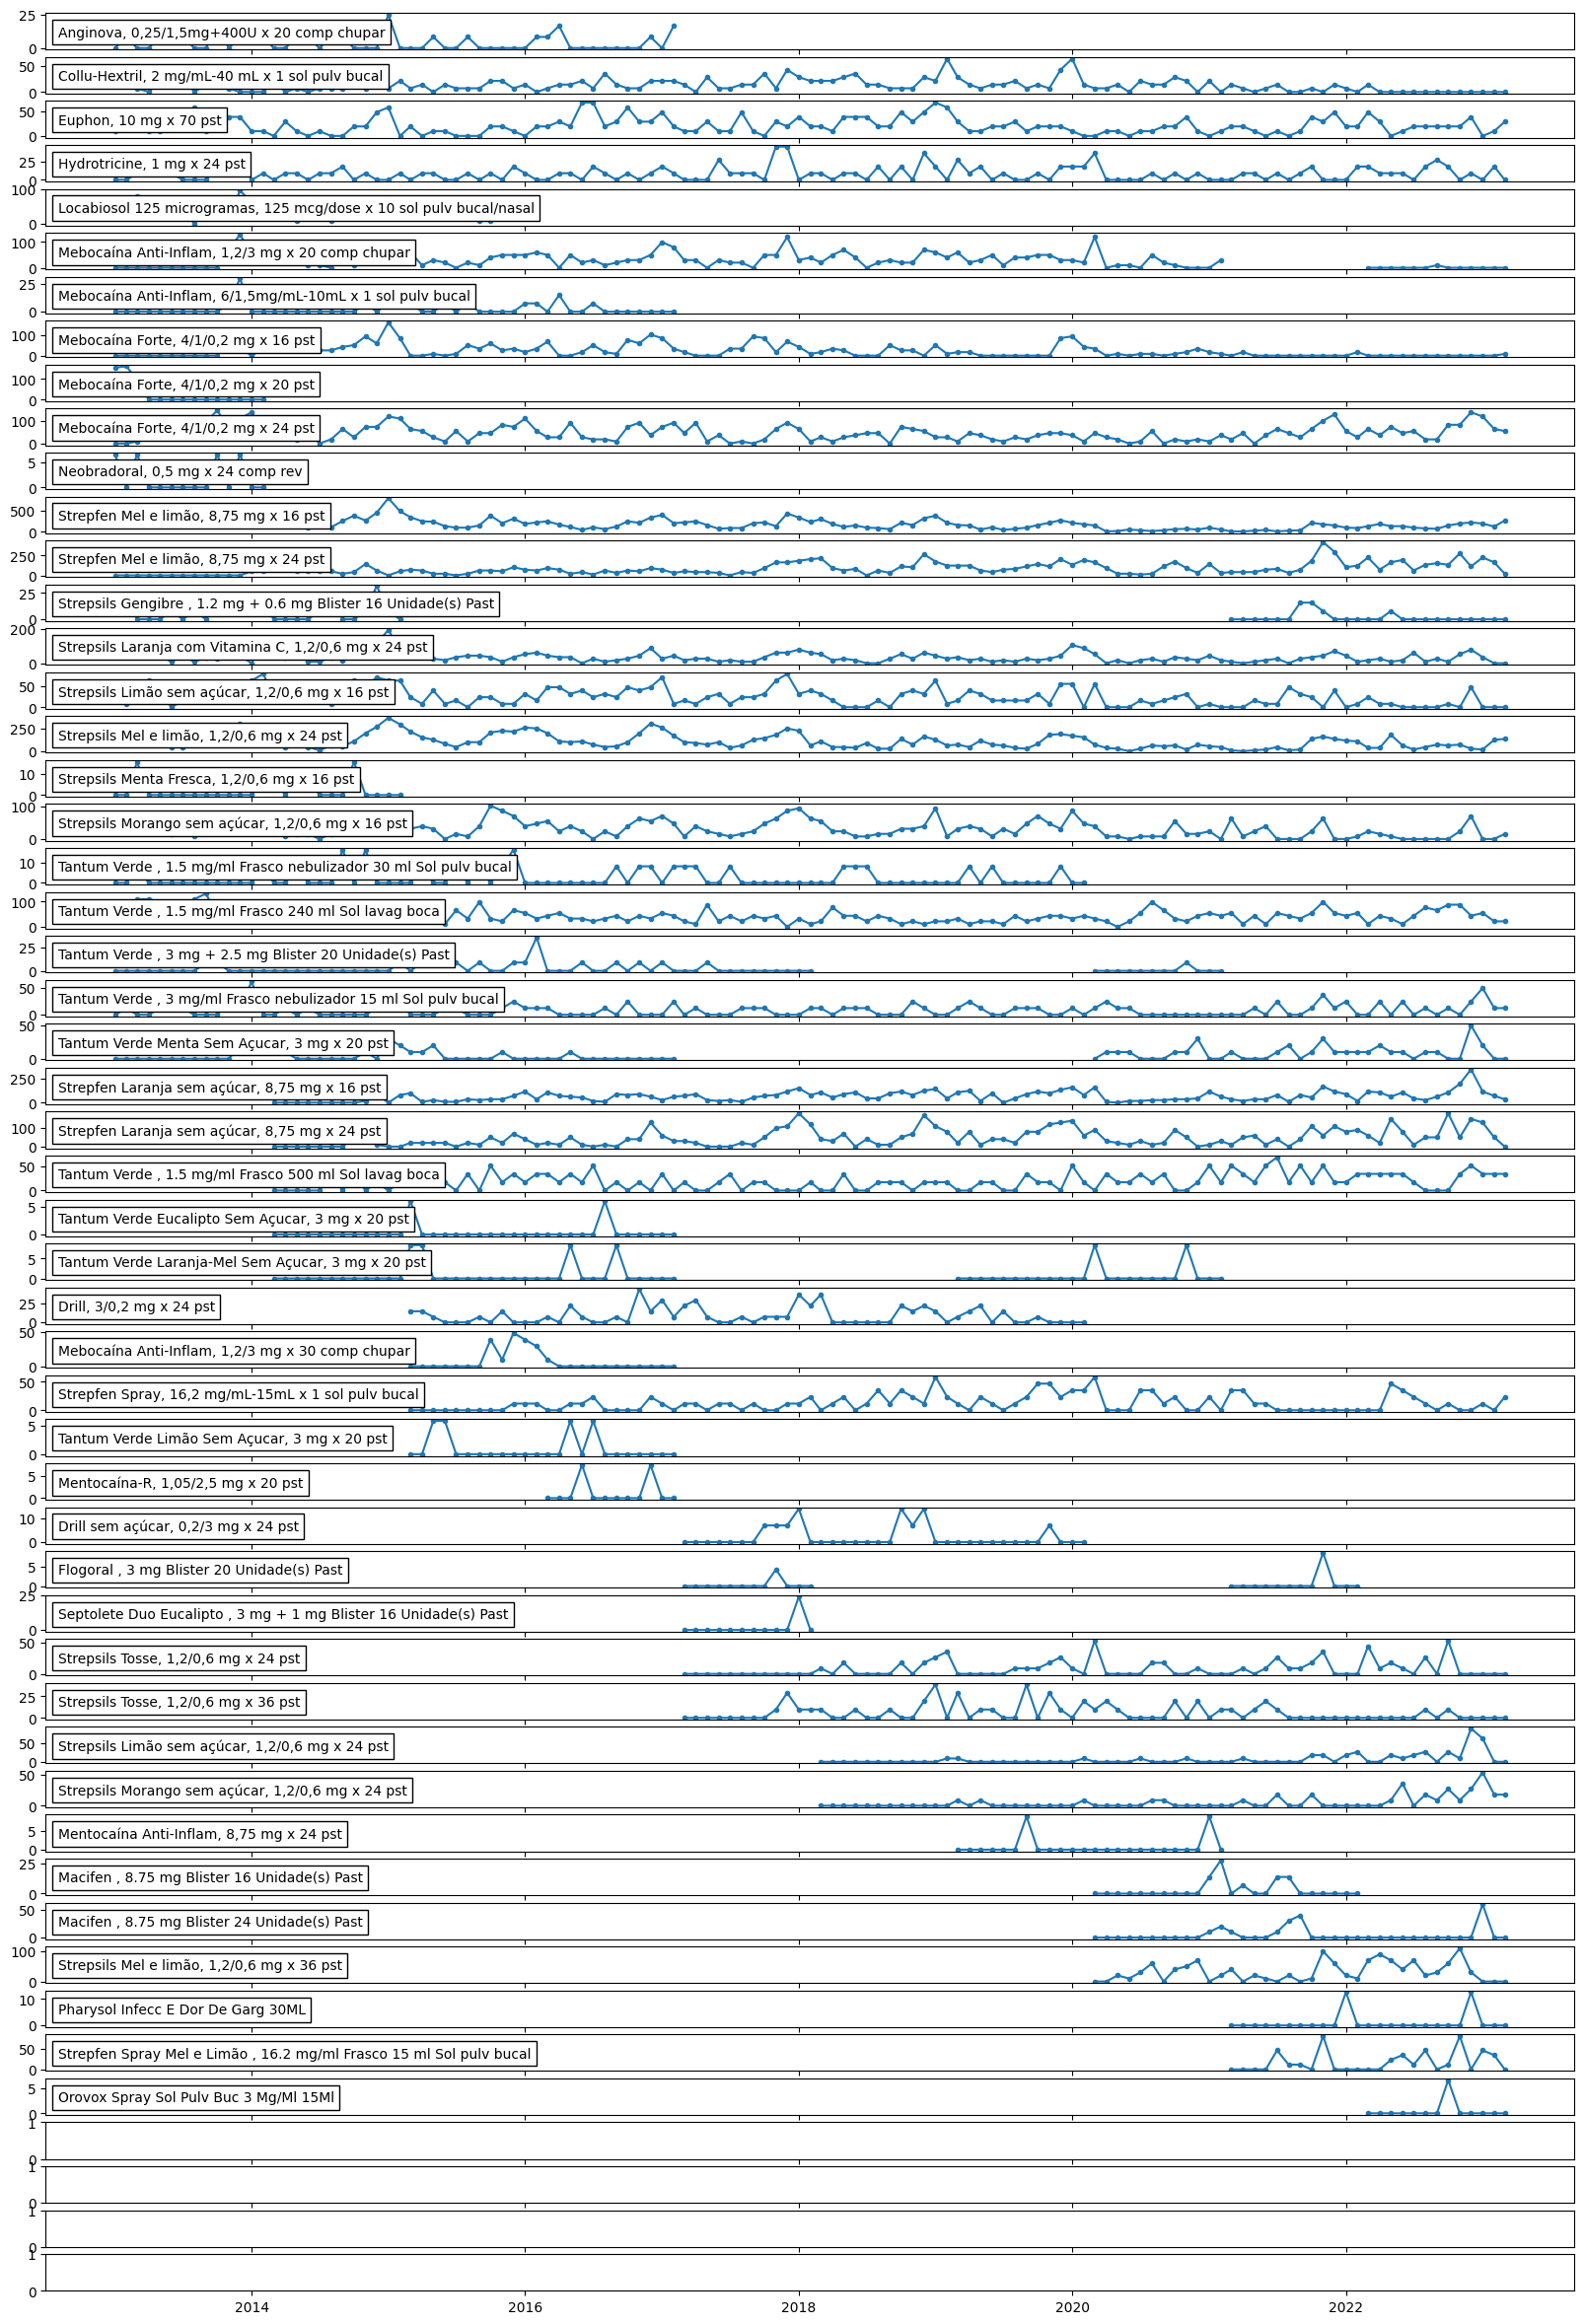

In [13]:
fig, ax = plt.subplots(52, 1, figsize=(20,30), sharex=True)
for i, col in enumerate(df.columns):
    ax[i].plot(df.loc[:,col], marker='.')
    med_name = df_metainfo.query('cod == @col').iloc[0,1]
    at = AnchoredText(med_name, loc="upper left")
    ax[i].add_artist(at)
plt.show()

In [14]:
with pd.option_context('display.max_rows', 10, 'display.min_rows', 25):
    display(df.describe().T.round(2))
    #display(df.mask(df == 0).describe().T.round(2))

,count,mean,std,min,25%,50%,75%,max
cod,,,,,,,,
9313106,50.0,4.30,6.08,0.0,0.00,0.00,8.27,24.81
4320396,123.0,12.67,12.11,0.0,7.05,7.05,21.15,63.45
8834101,123.0,21.01,16.94,0.0,9.75,19.50,29.25,68.25
9969600,123.0,8.55,9.96,0.0,0.00,9.22,9.22,46.10
4895983,38.0,37.07,22.14,0.0,17.50,35.00,52.50,96.25
...,...,...,...,...,...,...,...,...
5745377,37.0,4.84,12.76,0.0,0.00,0.00,0.00,59.70
5154745,37.0,31.86,31.49,0.0,0.00,19.98,59.94,109.89
6212787,25.0,1.01,3.49,0.0,0.00,0.00,0.00,12.62


In [15]:
df.to_csv('df_dados_DGR.csv')
df_metainfo.to_csv('df_metainfo_DGR.csv')

In [16]:
del at, ax, col, fig, i, med_name, numero_medicamentos

# 3. Agrupamento das séries por categorias de medicamentos

## 3.1. Tratamento dos dados


In [17]:
df_categ = pd.read_csv('categoria_medicamentos_garganta.csv', sep=';', encoding='cp1252')
df_categ.classif.value_counts()

classif
6.1.1 - De aplicação tópica    48
Name: count, dtype: int64

In [18]:
df_grouped = pd.merge(df_merged, df_categ.filter(['cod', 'classif']), on=['cod'], how='left')
df_grouped = df_grouped.drop(columns=['cod','nome','pvp']).groupby('classif').sum().T
df_grouped.index = pd.to_datetime(df_grouped.index)
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2013-01-01 to 2023-03-01
Data columns (total 1 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   6.1.1 - De aplicação tópica  123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [19]:
df_grouped.head()

classif,6.1.1 - De aplicação tópica
2013-01-01,1022.78
2013-02-01,942.22
2013-03-01,1152.90
2013-04-01,678.64
2013-05-01,814.43


## 3.2. Visualização das séries temporais

In [20]:
fig = px.line(df_grouped, x=df_grouped.index, y=df_grouped.columns)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

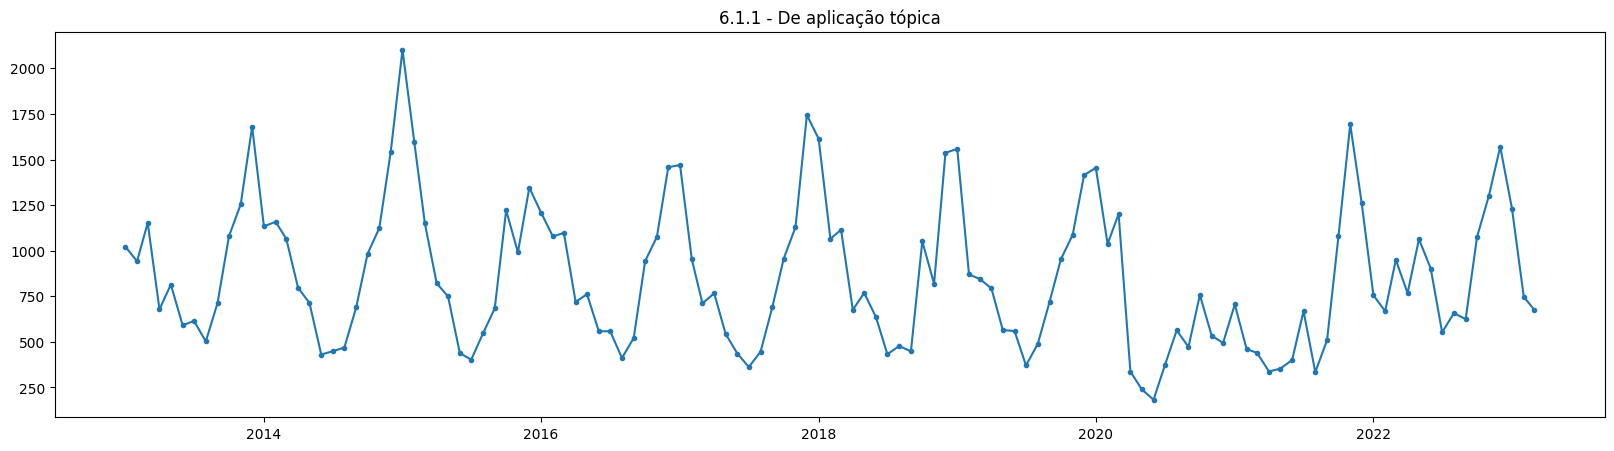

In [21]:
fig, ax = plt.subplots(figsize=(20, 5), sharex=True)
col = df_grouped.columns[0] 

ax.plot(df_grouped[col], marker='.')
ax.set_title(col)

plt.show()

# 4. Decomposição


## 4.1. Decomposição Aditiva

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposition_additive(df_grouped,col):
    decompose_additive = seasonal_decompose(df_grouped[col],model='additive')
    decompose_additive.plot()


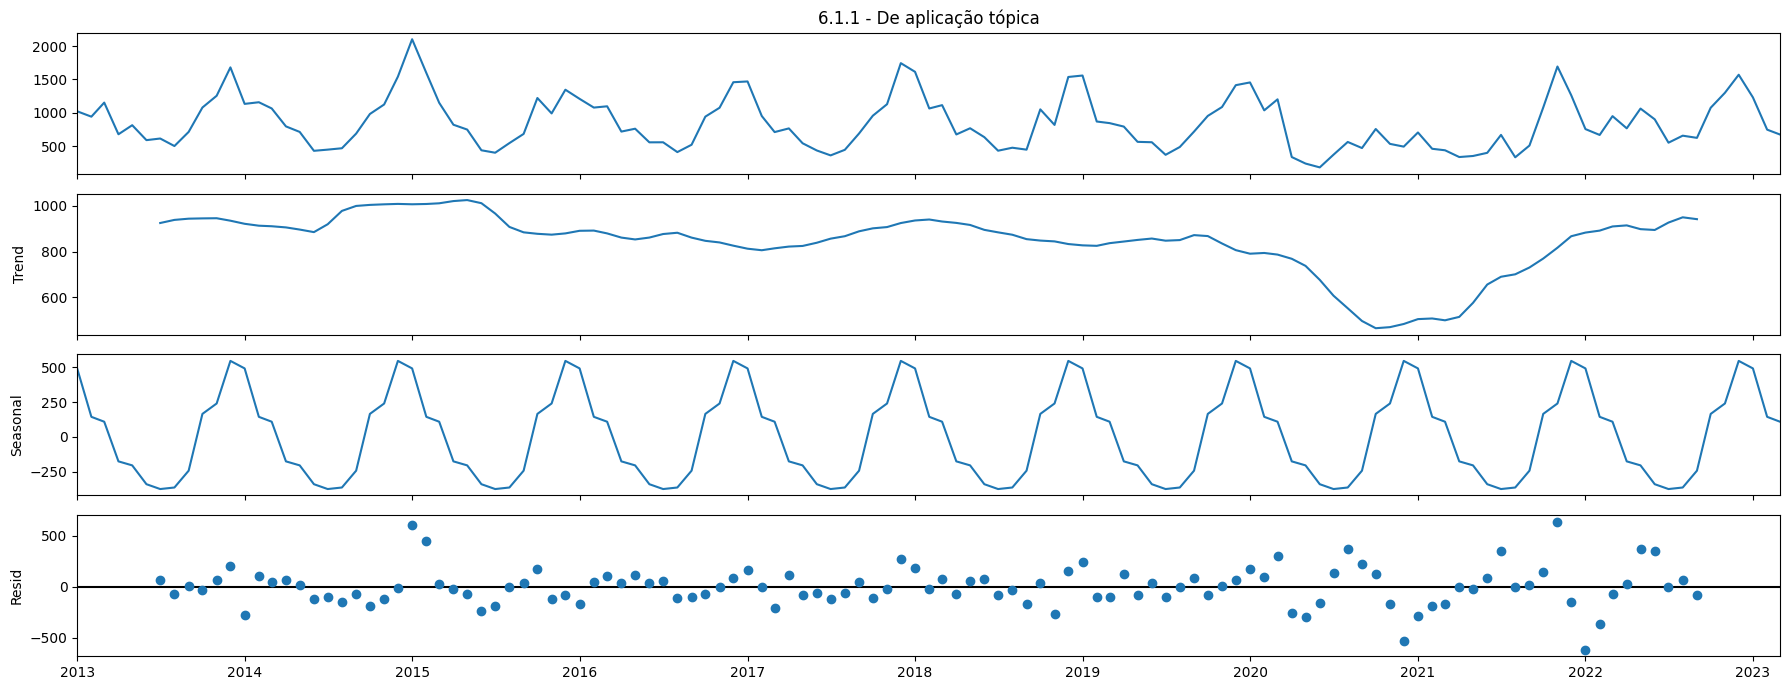

In [23]:
decomposition_additive(df_grouped,col)

In [24]:
def decomposition_additive(df, col):
    decompose_additive = seasonal_decompose(df[col], model='additive')

    # Accessing the decomposed values
    df_decomp_additive = pd.DataFrame({
        'observed': decompose_additive.observed,
        'trend': decompose_additive.trend,
        'seasonal': decompose_additive.seasonal,
        'residual': decompose_additive.resid
    })

    return df_decomp_additive

# Escolha a coluna desejada
col = df_grouped.columns[0] 

# Aplica a decomposição aditiva apenas para a coluna escolhida
result = decomposition_additive(df_grouped, col)

print(f"Decomposição aditiva para série '{col}':")
print(result.head(15))
print("\n" + "="*40 + "\n")


Decomposição aditiva para série '6.1.1 - De aplicação tópica':
            observed       trend    seasonal    residual
2013-01-01   1022.78         NaN  490.793277         NaN
2013-02-01    942.22         NaN  144.034851         NaN
2013-03-01   1152.90         NaN  109.122166         NaN
2013-04-01    678.64         NaN -174.866306         NaN
2013-05-01    814.43         NaN -203.563899         NaN
2013-06-01    590.64         NaN -338.335103         NaN
2013-07-01    614.97  925.260000 -373.032927   62.742927
2013-08-01    502.30  938.890417 -361.989510  -74.600907
2013-09-01    713.90  944.245417 -241.534093   11.188677
2013-10-01   1079.16  945.505000  165.098370  -31.443370
2013-11-01   1255.19  946.221250  239.598416   69.370334
2013-12-01   1680.51  935.364583  544.674758  200.470658
2014-01-01   1133.74  921.767917  490.793277 -278.821194
2014-02-01   1158.39  913.450833  144.034851  100.904316
2014-03-01   1065.25  911.013333  109.122166   45.114501




## 4.2. Decomposição STL


In [25]:
from statsmodels.tsa.seasonal import STL
def decomposition_STL(df_grouped,col):
    decompose_STL = STL(df_grouped[col]).fit()
    decompose_STL.plot()

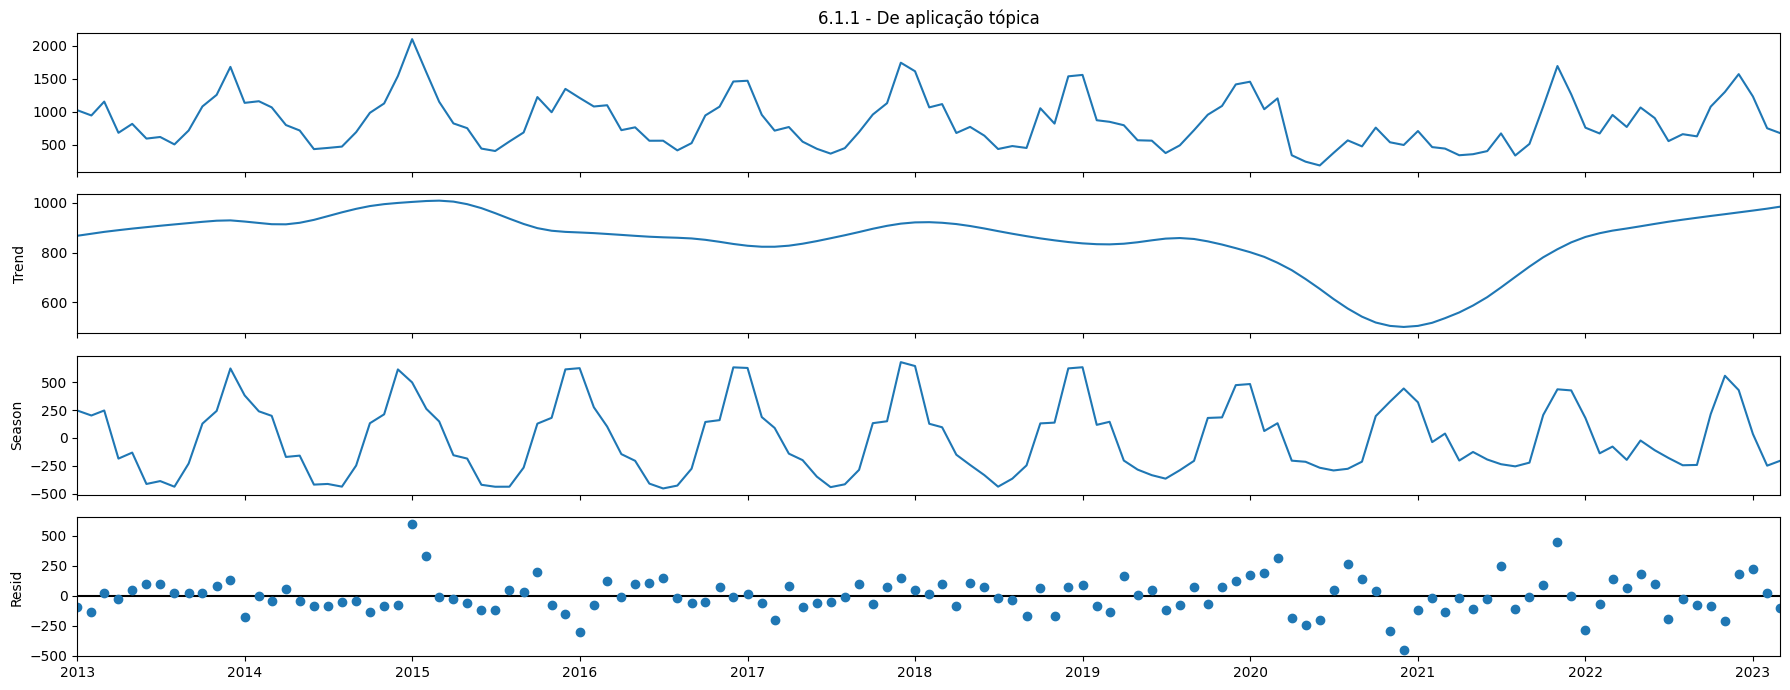

In [26]:
decomposition_STL(df_grouped,col)

In [27]:
def decomposition_STL(df, col):
    decompose_STL = STL(df[col]).fit()

    df_decomp_STL = pd.DataFrame({
        'observed': decompose_STL.observed,
        'trend': decompose_STL.trend,
        'seasonal': decompose_STL.seasonal,
        'residual': decompose_STL.resid
    })

    return df_decomp_STL

# Aplica a decomposição STL apenas para a primeira coluna do DataFrame
col = df_grouped.columns[0]
result = decomposition_STL(df_grouped, col)

print(f"Decomposição STL para série '{col}':")
print(result.head(5))
print("\n" + "="*40 + "\n")


Decomposição STL para série '6.1.1 - De aplicação tópica':
            observed       trend    seasonal    residual
2013-01-01   1022.78  867.402833  246.683659  -91.306492
2013-02-01    942.22  875.642962  201.584825 -135.007788
2013-03-01   1152.90  883.150619  246.485123   23.264258
2013-04-01    678.64  890.000328 -185.246179  -26.114148
2013-05-01    814.43  896.296233 -131.428909   49.562676




## 4.3. Caracteristicas STL

### 4.3.1. Força da tendência e da sazonalidade

In [28]:
def decomposition_STL(df_grouped, col):
    decompose_STL = STL(df_grouped[col]).fit()
    
    df_decomp_STL = pd.DataFrame({
        'observed': decompose_STL.observed,
        'trend': decompose_STL.trend,
        'seasonal': decompose_STL.seasonal,
        'residual': decompose_STL.resid
    })
    
    # Cálculo da força da tendência
    trend_var = np.var(df_decomp_STL['trend'] + df_decomp_STL['residual'])
    residual_var = np.var(df_decomp_STL['residual'])
    trend_strength = max(0, 1 - (residual_var / trend_var))
    
    # Cálculo da força da sazonalidade
    seasonal_var = np.var(df_decomp_STL['seasonal'] + df_decomp_STL['residual'])
    seasonal_strength = max(0, 1 - (residual_var / seasonal_var))
    
    return df_decomp_STL, trend_strength, seasonal_strength

for col in df_grouped:
    result, trend_strength, seasonal_strength = decomposition_STL(df_grouped, col)
        
    print(f"Decomposição STL para série '{col}':")
    print(result.head(5))
    print(f"Força da tendência para série '{col}': {trend_strength}")
    print(f"Força da sazonalidade para série '{col}': {seasonal_strength}")
    print("\n" + "="*40 + "\n")

Decomposição STL para série '6.1.1 - De aplicação tópica':
            observed       trend    seasonal    residual
2013-01-01   1022.78  867.402833  246.683659  -91.306492
2013-02-01    942.22  875.642962  201.584825 -135.007788
2013-03-01   1152.90  883.150619  246.485123   23.264258
2013-04-01    678.64  890.000328 -185.246179  -26.114148
2013-05-01    814.43  896.296233 -131.428909   49.562676
Força da tendência para série '6.1.1 - De aplicação tópica': 0.4848613151002049
Força da sazonalidade para série '6.1.1 - De aplicação tópica': 0.8359093954491268




In [29]:
def decomposition_STL(df, col):
    decompose_STL = STL(df[col]).fit()

    df_decomp_STL = pd.DataFrame({
        'observed': decompose_STL.observed,
        'trend': decompose_STL.trend,
        'seasonal': decompose_STL.seasonal,
        'residual': decompose_STL.resid
    })

    return df_decomp_STL

# Aplica a decomposição STL apenas para a primeira coluna do DataFrame
col = df_grouped.columns[0]
result = decomposition_STL(df_grouped, col)


## 4.4 Outliers

In [30]:
def outlier_tukey(df, column):
    """
    Given the data frame and a numeric column, outputs the outlier data frame.
    inputs: df - pandas data frame; column - string
    output: pandas data frame
    """
    Q1 = df.quantile(0.25).loc[column]
    Q3 = df.quantile(0.75).loc[column]
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    df_outliers = df.query(f'{column} < @lower_fence or {column} > @upper_fence')
    return df_outliers

In [31]:
for col in df_grouped:
    df_decomp_STL = decomposition_STL(df_grouped, col)
    
    # Detetar os outliers da coluna dos resíduos
    outliers = outlier_tukey(df_decomp_STL, 'residual')
    
    # Visualizar os outliers 
    cm = sns.color_palette("vlag", as_cmap=True)
    print(f"Outliers para a série '{col}':")
    display(outliers.filter(['residual']).style.background_gradient(cmap=cm))
    print("\n" + "="*40 + "\n")

Outliers para a série '6.1.1 - De aplicação tópica':


,residual
2015-01-01 00:00:00,599.876385
2015-02-01 00:00:00,328.498642
2020-12-01 00:00:00,-450.935725
2021-11-01 00:00:00,443.415183


## 4.5 Estacionariedade

### 4.5.1 Teste KPSS (Teste Kwiatkowski–Phillips–Schmidt–Shin)

In [32]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

for col in df_grouped:
    print(f"KPSS Teste para a série '{col}':")
    kpss_test(df_grouped[col])
    print("\n" + "="*40 + "\n")

KPSS Teste para a série '6.1.1 - De aplicação tópica':
Results of KPSS Test:
Test Statistic           0.160101
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64




C:\Users\Maria Inês\AppData\Local\Temp\ipykernel_32476\9991293.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




### 4.5.2 Teste ADF (Teste Dickey-Fuller Aumentado)

In [33]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

for col in df_grouped:
    print(f"Teste ADF para a série '{col}':")
    adf_test(df_grouped[col])
    print("\n" + "="*40 + "\n")

Teste ADF para a série '6.1.1 - De aplicação tópica':
Results of Dickey-Fuller Test:
Test Statistic                  -1.676522
p-value                          0.443248
#Lags Used                      11.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64




### 4.5.3 Normalidade

In [34]:
import scipy.stats as stats

def jarque_bera_test(timeseries):
    name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
    
    # Calcula a estatística de Jarque-Bera e p-value
    jb_stat, jb_pvalue = stats.jarque_bera(timeseries)
    
    # Calcula a assimetria e curtose
    skewness = stats.skew(timeseries)
    kurtosis = stats.kurtosis(timeseries)
    
    # Retorna os resultados
    return dict(zip(name, [jb_stat, jb_pvalue, skewness, kurtosis]))

for col in df_grouped:
    print(f"Teste Jarque-Bera test para a série '{col}':")
    result = jarque_bera_test(df_grouped[col])
    
    # Imprime os resultados em linhas separadas
    print(f"Jarque-Bera: {result['Jarque-Bera']}")
    print(f"Chi^2 two-tail prob.: {result['Chi^2 two-tail prob.']}")
    print(f"Skew: {result['Skew']}")
    print(f"Kurtosis: {result['Kurtosis']}")
    
    print("\n" + "="*40 + "\n")

Teste Jarque-Bera test para a série '6.1.1 - De aplicação tópica':
Jarque-Bera: 9.966070825459754
Chi^2 two-tail prob.: 0.006853228576365582
Skew: 0.6970814291529478
Kurtosis: -0.030151450643163713




# 5. Exportar dados para o notebook seguinte

In [35]:
df_grouped = df_grouped.reset_index()
df_grouped.to_csv('Dados_intermedios/df_nb1.csv', index=False)